In [1]:
%matplotlib inline


# Enhanced chroma


This notebook demonstrates a variety of techniques for enhancing chroma features.

Beyond the default parameter settings of librosa's chroma functions, we apply the following
enhancements:

    1. Over-sampling the frequency axis to reduce sensitivity to tuning deviations
    2. Harmonic-percussive-residual source separation to eliminate transients.
    3. Nearest-neighbor smoothing to eliminate passing tones and sparse noise.  This is inspired by the
       recurrence-based smoothing technique of
       `Cho and Bello, 2011 <http://ismir2011.ismir.net/papers/OS8-4.pdf>`_.
    4. Local median filtering to suppress remaining discontinuities.



In [2]:
# Code source: Brian McFee
# License: ISC
# sphinx_gallery_thumbnail_number = 6

from __future__ import print_function
import numpy as np
import scipy
import matplotlib.pyplot as plt

import librosa
import librosa.display
import sys
try:
    sys.getwindowsversion()
except AttributeError:
    isWindows = False
else:
    isWindows = True

if isWindows:
    import win32api,win32process,win32con
    pid = win32api.GetCurrentProcessId()
    handle = win32api.OpenProcess(win32con.PROCESS_ALL_ACCESS, True, pid)
    win32process.SetPriorityClass(handle, win32process.HIGH_PRIORITY_CLASS)

We'll use a track that has harmonic, melodic, and percussive elements



In [3]:
y, sr = librosa.load('Audio/Are You That Somebody.mp3')

First, let's plot the original chroma



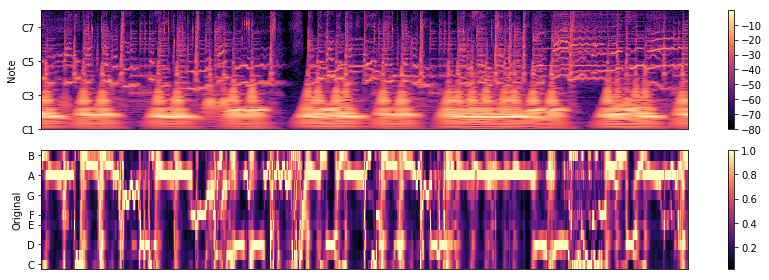

In [4]:
chroma_orig = librosa.feature.chroma_cqt(y=y, sr=sr)

# For display purposes, let's zoom in on a 15-second chunk from the middle of the song
idx = [slice(None), slice(*list(librosa.time_to_frames([45, 60])))]

# And for comparison, we'll show the CQT matrix as well.
C = np.abs(librosa.cqt(y=y, sr=sr, bins_per_octave=12*3, n_bins=7*12*3))


plt.figure(figsize=(12, 4))
plt.subplot(2, 1, 1)
librosa.display.specshow(librosa.amplitude_to_db(C, ref=np.max)[idx],
                         y_axis='cqt_note', bins_per_octave=12*3)
plt.colorbar()
plt.subplot(2, 1, 2)
librosa.display.specshow(chroma_orig[idx], y_axis='chroma')
plt.colorbar()
plt.ylabel('Original')
plt.tight_layout()

We can correct for minor tuning deviations by using 3 CQT
bins per semi-tone, instead of one



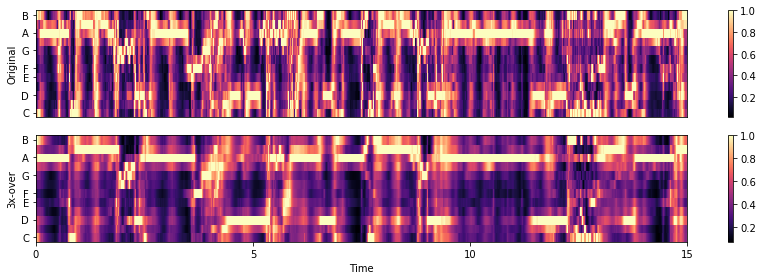

In [5]:
chroma_os = librosa.feature.chroma_cqt(y=y, sr=sr, bins_per_octave=12*3)


plt.figure(figsize=(12, 4))

plt.subplot(2, 1, 1)
librosa.display.specshow(chroma_orig[idx], y_axis='chroma')
plt.colorbar()
plt.ylabel('Original')


plt.subplot(2, 1, 2)
librosa.display.specshow(chroma_os[idx], y_axis='chroma', x_axis='time')
plt.colorbar()
plt.ylabel('3x-over')
plt.tight_layout()

That cleaned up some rough edges, but we can do better
by isolating the harmonic component.
We'll use a large margin for separating harmonics from percussives



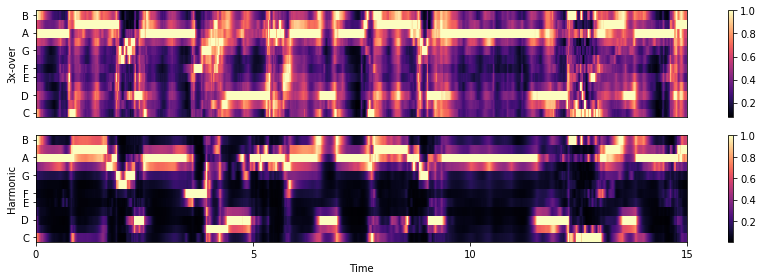

In [6]:
y_harm = librosa.effects.harmonic(y=y, margin=8)
chroma_os_harm = librosa.feature.chroma_cqt(y=y_harm, sr=sr, bins_per_octave=12*3)


plt.figure(figsize=(12, 4))

plt.subplot(2, 1, 1)
librosa.display.specshow(chroma_os[idx], y_axis='chroma')
plt.colorbar()
plt.ylabel('3x-over')

plt.subplot(2, 1, 2)
librosa.display.specshow(chroma_os_harm[idx], y_axis='chroma', x_axis='time')
plt.colorbar()
plt.ylabel('Harmonic')
plt.tight_layout()

There's still some noise in there though.
We can clean it up using non-local filtering.
This effectively removes any sparse additive noise from the features.



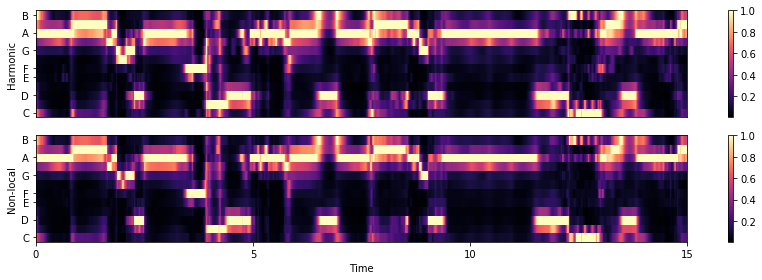

In [7]:
chroma_filter = np.minimum(chroma_os_harm,
                           librosa.decompose.nn_filter(chroma_os_harm,
                                                       aggregate=np.median,
                                                       metric='cosine'))


plt.figure(figsize=(12, 4))

plt.subplot(2, 1, 1)
librosa.display.specshow(chroma_os_harm[idx], y_axis='chroma')
plt.colorbar()
plt.ylabel('Harmonic')

plt.subplot(2, 1, 2)
librosa.display.specshow(chroma_filter[idx], y_axis='chroma', x_axis='time')
plt.colorbar()
plt.ylabel('Non-local')
plt.tight_layout()

Local discontinuities and transients can be suppressed by
using a horizontal median filter.



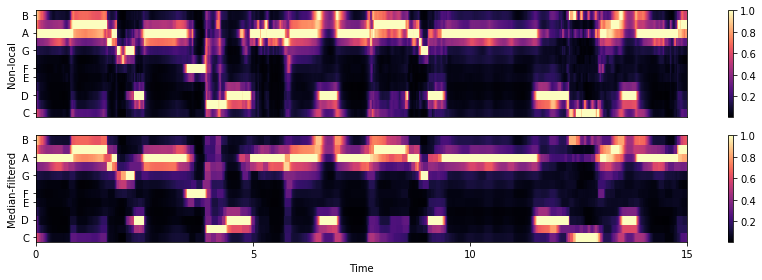

In [8]:
chroma_smooth = scipy.ndimage.median_filter(chroma_filter, size=(1, 9))


plt.figure(figsize=(12, 4))

plt.subplot(2, 1, 1)
librosa.display.specshow(chroma_filter[idx], y_axis='chroma')
plt.colorbar()
plt.ylabel('Non-local')

plt.subplot(2, 1, 2)
librosa.display.specshow(chroma_smooth[idx], y_axis='chroma', x_axis='time')
plt.colorbar()
plt.ylabel('Median-filtered')
plt.tight_layout()

A final comparison between the CQT, original chromagram
and the result of our filtering.



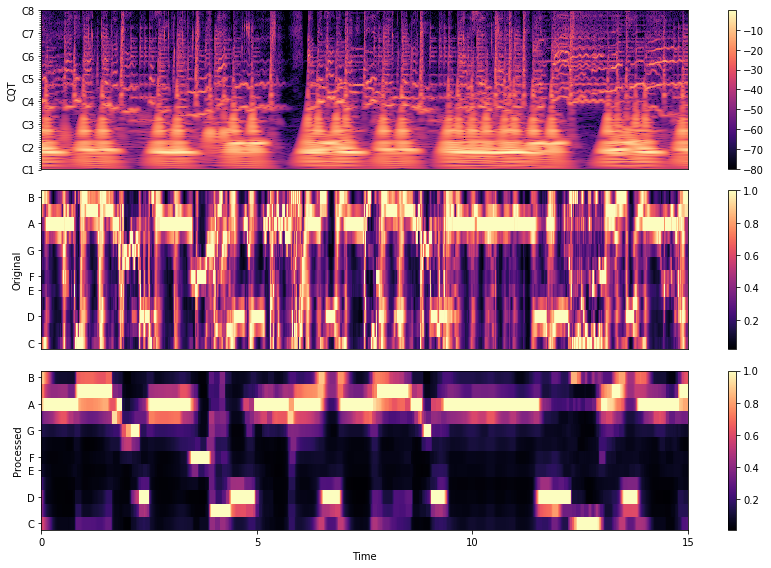

In [9]:
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
librosa.display.specshow(librosa.amplitude_to_db(C, ref=np.max)[idx],
                         y_axis='cqt_note', bins_per_octave=12*3)
plt.colorbar()
plt.ylabel('CQT')
plt.subplot(3, 1, 2)
librosa.display.specshow(chroma_orig[idx], y_axis='chroma')
plt.ylabel('Original')
plt.colorbar()
plt.subplot(3, 1, 3)
librosa.display.specshow(chroma_smooth[idx], y_axis='chroma', x_axis='time')
plt.ylabel('Processed')
plt.colorbar()
plt.tight_layout()
plt.show()